# Proyek Analisis Sentimen

## Import Library

In [106]:
!pip install --upgrade nltk
!pip install textblob

In [107]:
import pandas as pd
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Dataset

In [108]:
# Membaca dan menampilkan lima data pertama
df = pd.read_csv('review_game_mobile_legends.csv')
df.head()

,review
0,Moonton has very poor matchmaking. Sometimes s...
1,"Was a great game, simple to play, easy to unde..."
2,"Dear admin, I want to convey the problem I am ..."
3,"Dear Moonton, if you make a game that's correc..."
4,"Mobile Legends has a lot of potential, but it ..."


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72000 entries, 0 to 71999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  72000 non-null  object
dtypes: object(1)
memory usage: 562.6+ KB


In [110]:
# Cek duplikasi
duplicates = df.duplicated()
print(duplicates.value_counts())
print('Jumlah data : ',len(df))

False    71952
True        48
Name: count, dtype: int64
Jumlah data :  72000


In [111]:
# Hapus duplikasi
df = df.drop_duplicates()

In [112]:
# Cek ulang duplikasi
duplicates = df.duplicated()
print(duplicates.value_counts())
print('Jumlah data : ',len(df))

False    71952
Name: count, dtype: int64
Jumlah data :  71952


## Preprocessing Text

### Cleaning Text

In [113]:
def cleaningText(text):
  text = re.sub(r'@[\w]+', '', text)  # Menghapus mention
  text = re.sub(r'#\w+', '', text)  # Menghapus hashtag
  text = re.sub(r'RT\s', '', text)  # Menghapus RT
  text = re.sub(r'http\S+', '', text)  # Menghapus tautan (URL)
  text = re.sub(r'\d+', '', text)  # Menghapus angka
  text = re.sub(r'[^\w\s]', '', text)  # Menghapus tanda baca
  text = re.sub(r'\n', ' ', text)  # Mengganti newline dengan spasi
  text = text.strip()  # Menghapus spasi ekstra di awal dan akhir
  return text

### Case Folding

In [114]:
def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

### Tokenizing

In [115]:
def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

### Filtering

In [116]:
def filteringText(tokens):
    listStopwords = set(stopwords.words('english'))
    filtered = [word for word in tokens if word.lower() not in listStopwords]
    return filtered

### Stemming

In [117]:
ps = PorterStemmer()

def stemmingText(tokens):
    stemmed_words = [ps.stem(word) for word in tokens]  # Stemming pada setiap token
    return stemmed_words

### To Sentence

In [118]:
def toSentence(tokens):
    sentence = ' '.join(tokens)  # Menggabungkan daftar token menjadi kalimat
    return sentence

### Hasil

In [119]:
# Pipeline Preprocessing
df['text_clean'] = df['review'].apply(cleaningText)
df['text_casefoldingText'] = df['text_clean'].apply(casefoldingText)
df['text_tokenizingText'] = df['text_casefoldingText'].apply(tokenizingText)
df['text_stopword'] = df['text_tokenizingText'].apply(filteringText)
df['text_stemming'] = df['text_stopword'].apply(stemmingText)
df['text_akhir'] = df['text_stemming'].apply(toSentence)

# Hasil
df

,review,text_clean,text_casefoldingText,text_tokenizingText,text_stopword,text_stemming,text_akhir
0,Moonton has very poor matchmaking. Sometimes s...,Moonton has very poor matchmaking Sometimes so...,moonton has very poor matchmaking sometimes so...,"[moonton, has, very, poor, matchmaking, someti...","[moonton, poor, matchmaking, sometimes, player...","[moonton, poor, matchmak, sometim, player, als...",moonton poor matchmak sometim player also expe...
1,"Was a great game, simple to play, easy to unde...",Was a great game simple to play easy to unders...,was a great game simple to play easy to unders...,"[was, a, great, game, simple, to, play, easy, ...","[great, game, simple, play, easy, understand, ...","[great, game, simpl, play, easi, understand, y...",great game simpl play easi understand yet hard...
2,"Dear admin, I want to convey the problem I am ...",Dear admin I want to convey the problem I am e...,dear admin i want to convey the problem i am e...,"[dear, admin, i, want, to, convey, the, proble...","[dear, admin, want, convey, problem, experienc...","[dear, admin, want, convey, problem, experienc...",dear admin want convey problem experienc game ...
3,"Dear Moonton, if you make a game that's correc...",Dear Moonton if you make a game thats correct ...,dear moonton if you make a game thats correct ...,"[dear, moonton, if, you, make, a, game, thats,...","[dear, moonton, make, game, thats, correct, li...","[dear, moonton, make, game, that, correct, lit...",dear moonton make game that correct littl time...
4,"Mobile Legends has a lot of potential, but it ...",Mobile Legends has a lot of potential but it c...,mobile legends has a lot of potential but it c...,"[mobile, legends, has, a, lot, of, potential, ...","[mobile, legends, lot, potential, comes, stren...","[mobil, legend, lot, potenti, come, strength, ...",mobil legend lot potenti come strength weak fe...
...,...,...,...,...,...,...,...
71995,English is not my first language so bare with ...,English is not my first language so bare with ...,english is not my first language so bare with ...,"[english, is, not, my, first, language, so, ba...","[english, first, language, bare, game, good, m...","[english, first, languag, bare, game, good, ma...",english first languag bare game good match sys...
71996,I always play this game for almost everyday. T...,I always play this game for almost everyday Th...,i always play this game for almost everyday th...,"[i, always, play, this, game, for, almost, eve...","[always, play, game, almost, everyday, thing, ...","[alway, play, game, almost, everyday, thing, a...",alway play game almost everyday thing alway jo...
71997,The keeps crashing even though im only in the ...,The keeps crashing even though im only in the ...,the keeps crashing even though im only in the ...,"[the, keeps, crashing, even, though, im, only,...","[keeps, crashing, even, though, im, meduim, gr...","[keep, crash, even, though, im, meduim, graphi...",keep crash even though im meduim graphic happe...
71998,"It's still a great game<< old review, 2019 rev...",Its still a great game old review review VG h...,its still a great game old review review vg h...,"[its, still, a, great, game, old, review, revi...","[still, great, game, old, review, review, vg, ...","[still, great, game, old, review, review, vg, ...",still great game old review review vg fail kee...


## Pelabelan

In [120]:
from textblob import TextBlob

# Menghitung subjektivitas
def subjektivitas(tr_text):
    return TextBlob(tr_text).sentiment.subjectivity

# Menghitung polaritas
def polaritas(tr_text):
    return TextBlob(tr_text).sentiment.polarity

# Hasil sentimen berdasarkan nilai polaritas
def hasilSentimen(nilai):
    if nilai < 0:
        return 'negatif'
    elif nilai == 0:
        return 'netral'
    else:
        return 'positif'

df['subjektivitas'] = df['text_akhir'].apply(subjektivitas)
df['polaritas'] = df['text_akhir'].apply(polaritas)
df['sentimen'] = df['polaritas'].apply(hasilSentimen)

df.head()

,review,text_clean,text_casefoldingText,text_tokenizingText,text_stopword,text_stemming,text_akhir,subjektivitas,polaritas,sentimen
0,Moonton has very poor matchmaking. Sometimes s...,Moonton has very poor matchmaking Sometimes so...,moonton has very poor matchmaking sometimes so...,"[moonton, has, very, poor, matchmaking, someti...","[moonton, poor, matchmaking, sometimes, player...","[moonton, poor, matchmak, sometim, player, als...",moonton poor matchmak sometim player also expe...,0.628571,-0.514286,negatif
1,"Was a great game, simple to play, easy to unde...",Was a great game simple to play easy to unders...,was a great game simple to play easy to unders...,"[was, a, great, game, simple, to, play, easy, ...","[great, game, simple, play, easy, understand, ...","[great, game, simpl, play, easi, understand, y...",great game simpl play easi understand yet hard...,0.438492,0.049868,positif
2,"Dear admin, I want to convey the problem I am ...",Dear admin I want to convey the problem I am e...,dear admin i want to convey the problem i am e...,"[dear, admin, i, want, to, convey, the, proble...","[dear, admin, want, convey, problem, experienc...","[dear, admin, want, convey, problem, experienc...",dear admin want convey problem experienc game ...,0.400000,-0.400000,negatif
3,"Dear Moonton, if you make a game that's correc...",Dear Moonton if you make a game thats correct ...,dear moonton if you make a game thats correct ...,"[dear, moonton, if, you, make, a, game, thats,...","[dear, moonton, make, game, thats, correct, li...","[dear, moonton, make, game, that, correct, lit...",dear moonton make game that correct littl time...,0.597222,0.151852,positif
4,"Mobile Legends has a lot of potential, but it ...",Mobile Legends has a lot of potential but it c...,mobile legends has a lot of potential but it c...,"[mobile, legends, has, a, lot, of, potential, ...","[mobile, legends, lot, potential, comes, stren...","[mobil, legend, lot, potenti, come, strength, ...",mobil legend lot potenti come strength weak fe...,0.627381,-0.144048,negatif


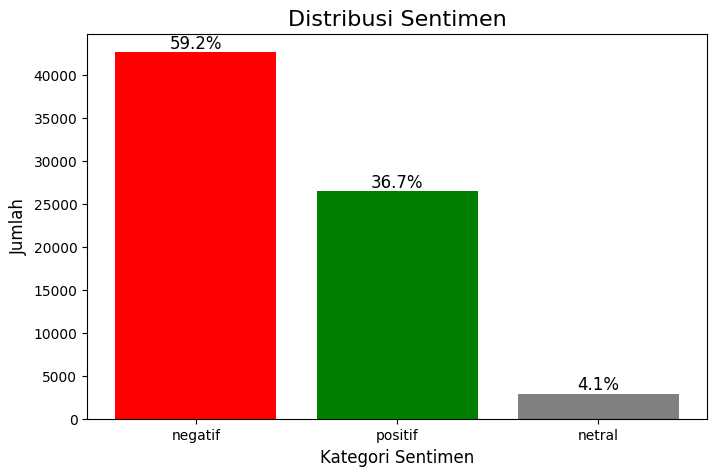

In [121]:
# Menampilkan distribusi sentimen dalam bentuk grafik batang
sentimen_counts = df['sentimen'].value_counts()

total_count = sentimen_counts.sum()

colors = {'positif': 'green', 'netral': 'gray', 'negatif': 'red'}

plt.figure(figsize=(8, 5))
bars = plt.bar(sentimen_counts.index, sentimen_counts.values, color=[colors[x] for x in sentimen_counts.index])

# Persentase tiap kategori
for bar in bars:
    height = bar.get_height()
    percentage = (height / total_count) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=12)

plt.title('Distribusi Sentimen', fontsize=16)
plt.xlabel('Kategori Sentimen', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()


## Data Splitting dan Ekstraksi Fitur

### TF - IDF

In [124]:
X = df['text_akhir']
y = df['sentimen']

# Membagi dataset menjadi data latih (70%) dan data uji (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Membuat objek TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

## Modelling

### Logistic Regression

In [125]:
# Model Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Prediksi pada data latih dan data uji
y_train_pred = model.predict(X_train_tfidf)
y_test_pred = model.predict(X_test_tfidf)

# Menghitung akurasi
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'Akurasi pada data latih: {train_accuracy:.2f}')
print(f'Akurasi pada data uji: {test_accuracy:.2f}')

joblib.dump(model, 'sentiment_model.pkl')

Akurasi pada data latih: 0.97
Akurasi pada data uji: 0.94


['sentiment_model.pkl']